Step 0/7068 completed. Current regime: II
Step 100/7068 completed. Current regime: II
Step 200/7068 completed. Current regime: II
Step 300/7068 completed. Current regime: II
Step 400/7068 completed. Current regime: II
Step 500/7068 completed. Current regime: II
Step 600/7068 completed. Current regime: II
Step 700/7068 completed. Current regime: II
Step 800/7068 completed. Current regime: II
Step 900/7068 completed. Current regime: II
Step 1000/7068 completed. Current regime: II
Step 1100/7068 completed. Current regime: II
Step 1200/7068 completed. Current regime: II
Step 1300/7068 completed. Current regime: II
Step 1400/7068 completed. Current regime: II
Step 1500/7068 completed. Current regime: II
Step 1600/7068 completed. Current regime: II
Step 1700/7068 completed. Current regime: II
Step 1800/7068 completed. Current regime: II
Step 1900/7068 completed. Current regime: II
Step 2000/7068 completed. Current regime: II
Step 2100/7068 completed. Current regime: II
Step 2200/7068 complet

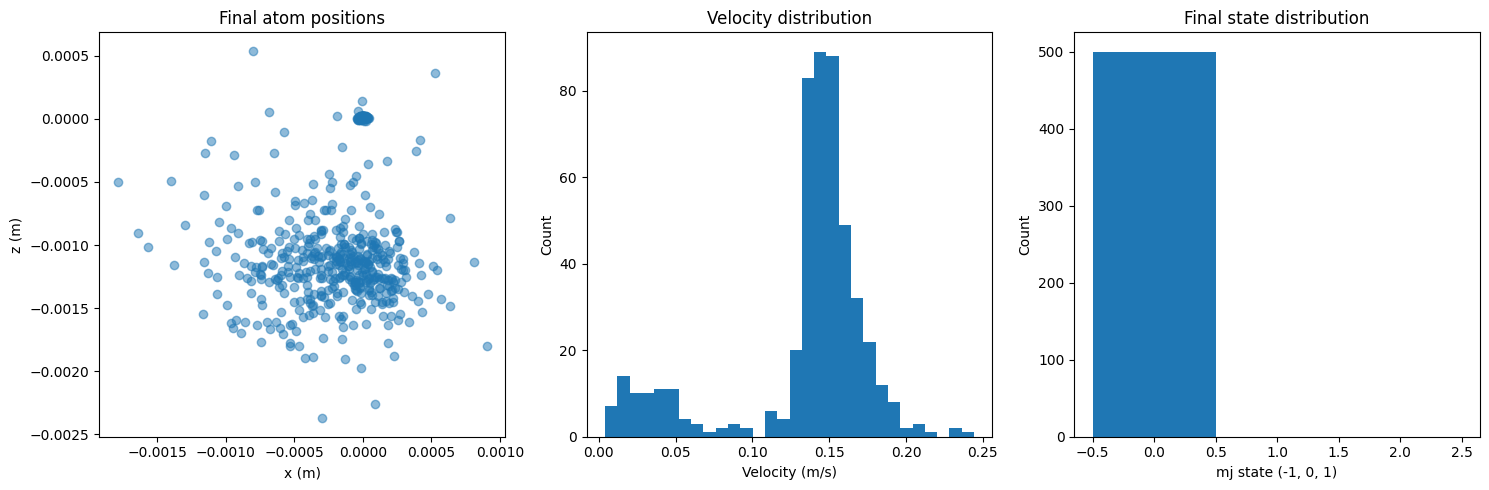

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, hbar, mu_0, c, elementary_charge as e, k as kB

# Constants for ^88Sr 5s^2 ^1S_0 → 5s5p ^3P_1 transition
m = 87.62 * 1.66e-27  # mass of Sr-88 in kg
g = 9.81  # acceleration due to gravity in m/s^2
gamma = 2 * np.pi * 7.5e3  # natural linewidth
lambda_light = 689e-9  # wavelength of light in m
k = 2 * np.pi / lambda_light  # wavevector
gamma_B = 0.08  # magnetic field gradient in T/m
mu_B = 9.274e-24  # Bohr magneton
g_factor = 1.5  # Landé g-factor for 3P1 state

# Simulation parameters
N_atoms = 500  # number of atoms
dt = 0.1 / gamma  # time step
t_total = 15e-3  # total simulation time
steps = int(t_total / dt)

# Define laser beam directions and polarizations
beam_directions = np.array([[1,0,0], [-1,0,0], [0,1,0], [0,-1,0], [0,0,1], [0,0,-1]])
beam_polarizations = np.array([
    [0, 1, -1j],  [0, 1, 1j],   # σ- for +x, σ+ for -x
    [1, 0, -1j],  [1, 0, 1j],   # σ- for +y, σ+ for -y
    [-1, -1j, 0], [-1, 1j, 0]   # σ- for +z, σ+ for -z
]) / np.sqrt(2)

def initialize_atoms(N, initial_temp, ellipsoid_radii):
    # Create positions in a user-defined ellipsoid
    u = np.random.random(N)
    v = np.random.random(N)
    w = np.random.random(N)
    
    theta = 2 * np.pi * u
    phi = np.arccos(2 * v - 1)
    r = np.cbrt(w)
    
    x = ellipsoid_radii[0] * r * np.sin(phi) * np.cos(theta)
    y = ellipsoid_radii[1] * r * np.sin(phi) * np.sin(theta)
    z = ellipsoid_radii[2] * r * np.cos(phi)
    
    positions = np.column_stack((x, y, z))
    
    # Create velocities from 3D-Boltzmann distribution
    velocities = np.random.normal(0, np.sqrt(kB * initial_temp / m), (N, 3))
    
    # Initialize all atoms in ground state (J=0, mj=0)
    states = np.zeros(N, dtype=int)
    
    return positions, velocities, states

def quadrupole_field(pos):
    """
    Calculate the quadrupole magnetic field B = γ × (x𝑥̂ + y𝑦̂ - 2z𝑧̂)
    """
    x, y, z = pos
    return gamma_B * np.array([x, y, -2*z])

def calculate_coupling_strengths(B_field, laser_polarization):
    """
    Calculate the coupling strengths Wj based on the local magnetic field
    and the polarization of the nMOT laser beam.
    
    Args:
    B_field (np.array): Local magnetic field vector
    laser_polarization (np.array): Laser polarization in Cartesian coordinates
    
    Returns:
    np.array: Coupling strengths for mj = -1, 0, 1 transitions
    """
    # Convert laser polarization from Cartesian to spherical basis
    E_spherical = cartesian_to_spherical(laser_polarization)
    
    # Calculate rotation angles
    B_unit = B_field / np.linalg.norm(B_field)
    theta = np.arccos(B_unit[2])
    phi = np.arctan2(B_unit[1], B_unit[0])
    
    # Construct rotation matrix Mq(θ)
    M_q = construct_rotation_matrix(theta)
    
    # Rotate polarization to local atomic frame
    E_prime = M_q @ E_spherical
    
    # Calculate coupling strengths
    W = np.abs(E_prime)**2
    
    return W

def cartesian_to_spherical(E_cartesian):
    """
    Convert electric field from Cartesian to spherical basis.
    """
    E_x, E_y, E_z = E_cartesian
    E_spherical = np.array([
        -1/np.sqrt(2) * (E_x + 1j*E_y),  # E^1
        E_z,                             # E^0
        1/np.sqrt(2) * (E_x - 1j*E_y)    # E^-1
    ])
    return E_spherical

def construct_rotation_matrix(theta):
    """
    Construct the rotation matrix Mq(θ) as described in the content.
    """
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    M_q = 0.5 * np.array([
        [1 + cos_theta, -np.sqrt(2)*sin_theta, 1 - cos_theta],
        [np.sqrt(2)*sin_theta, 2*cos_theta, -np.sqrt(2)*sin_theta],
        [1 - cos_theta, np.sqrt(2)*sin_theta, 1 + cos_theta]
    ])
    return M_q

def zeeman_splitting(B):
    """
    Calculate the Zeeman splitting Δωz = gμB|B|/ℏ
    """
    return g_factor * mu_B * np.linalg.norm(B) / hbar

def detuning(pos, vel, laser_k, Delta, mj):
    B = quadrupole_field(pos)
    delta_z = zeeman_splitting(B) * mj
    return Delta - np.dot(laser_k, vel) - delta_z

def check_resonance_condition(pos, vel, laser_k, Delta, mj):
    return np.abs(detuning(pos, vel, laser_k, Delta, mj)) < gamma

def check_zeeman_condition(pos):
    B = quadrupole_field(pos)
    B_mag = np.linalg.norm(B)
    zeeman_splitting = mu_B * g_factor * B_mag / hbar
    return zeeman_splitting > 10 * gamma  # Zeeman splitting much greater than linewidth

def scattering_rate(pos, vel, laser_k, laser_pol, Delta, S, mj):
    delta = detuning(pos, vel, laser_k, Delta, mj)
    B = quadrupole_field(pos)
    W = calculate_coupling_strengths(B, laser_pol)[mj+1]  # +1 because mj goes from -1 to 1
    return (gamma / 2) * (W * S / (1 + W * S + 4 * (delta / gamma)**2))

def determine_regime(S, Delta):
    if S > 1 and np.abs(Delta) < gamma * np.sqrt(1 + S):
        return "I"  # Doppler regime
    elif S > 1 and np.abs(Delta) > gamma * np.sqrt(1 + S):
        return "II"  # Power-broadened regime
    else:
        return "III"  # Quantum regime

def run_simulation(positions, velocities, states, Delta, S):
    regime = determine_regime(S, Delta)
    for step in range(steps):
        for i in range(N_atoms):
            if not check_zeeman_condition(positions[i]):
                continue  # Skip this atom if Zeeman condition is not met

            # Calculate scattering rates for each beam and each mj state
            rates = [[scattering_rate(positions[i], velocities[i], k * beam_directions[j],
                                      beam_polarizations[j], Delta, S, mj)
                      for mj in [-1, 0, 1]]
                     for j in range(6)]
            total_rate = sum(sum(beam_rates) for beam_rates in rates)
        
            
            # Determine if a scattering event occurs
            scattering_event = np.random.random() < total_rate * dt

            if scattering_event:
                # Choose which beam and mj state caused the absorption
                flat_rates = [rate for beam_rates in rates for rate in beam_rates]
                choice = np.random.choice(18, p=np.array(flat_rates)/total_rate)
                beam_index, mj = divmod(choice, 3)
                mj -= 1  # Convert back to -1, 0, 1
                
                # Check resonance condition
                if check_resonance_condition(positions[i], velocities[i], k * beam_directions[beam_index], Delta, mj):
                    # Calculate momentum kicks
                    k_i = k * beam_directions[beam_index]
                    phi = np.random.uniform(0, 2*np.pi)
                    theta = np.arccos(1 - 2*np.random.random())
                    k_s = k * np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
                    
                    # Update velocity with absorption, emission, and gravity
                    velocities[i] += (hbar / m) * (k_i + k_s) + np.array([0, 0, -g]) * dt
                    
                    # Update atomic state
                    states[i] = mj + 1  # Store as 0, 1, 2 for simplicity
                    
                    # Reset to ground state after emission
                    states[i] = 0
            else:
                # Update velocity and position without scattering
                velocities[i] += np.array([0, 0, -g]) * dt
                positions[i] += velocities[i] * dt + 0.5 * np.array([0, 0, -g]) * dt**2

            # Update position for scattering case
            if scattering_event:
                positions[i] += velocities[i] * dt
        
        if step % 100 == 0:
            print(f"Step {step}/{steps} completed. Current regime: {regime}")
    
    return positions, velocities, states

# Set initial conditions and run simulation
Delta = -2 * np.pi * 200e3  # detuning
S = 10  # saturation parameter
initial_temp = 1e-6  # initial temperature in K
ellipsoid_radii = [1e-4, 1e-4, 2e-4]  # example radii for the initial ellipsoid


positions, velocities, states = initialize_atoms(N_atoms, initial_temp, ellipsoid_radii)
final_positions, final_velocities, final_states = run_simulation(positions, velocities, states, Delta, S)

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(final_positions[:, 0], final_positions[:, 2], alpha=0.5)
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.title('Final atom positions')

plt.subplot(132)
plt.hist(np.linalg.norm(final_velocities, axis=1), bins=30)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Count')
plt.title('Velocity distribution')

plt.subplot(133)
plt.hist(final_states, bins=[-0.5, 0.5, 1.5, 2.5])
plt.xlabel('mj state (-1, 0, 1)')
plt.ylabel('Count')
plt.title('Final state distribution')

plt.tight_layout()
plt.show()